**Modeling growth and propagation of bacterial colonies on flat surfaces: branching colony**

This is the exact same as the circular colony protocol notebook, except that a few parameters in the COMETS model have been changed to cause the colony to branch.

In [2]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import numpy as np
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/COMETS-Python-Toolbox")
import comets as c

First, let's make a "toy" model, using functionality of cobrapy. It directly converts extracellular carbon to biomass. 

In [3]:
carbon = cobra.Metabolite("carbon",
                           compartment = "e")
carbon_exch = cobra.Reaction("Carbon_exch",
                            lower_bound = -1.,
                            upper_bound = 1000.)
carbon_exch.add_metabolites({carbon: -1.})
Biomass = cobra.Reaction("Biomass",
                        lower_bound = 0.,
                        upper_bound = 1000.)
Biomass.add_metabolites({carbon: -1.})
toy = cobra.Model("toy")
toy.add_reactions([carbon_exch, Biomass])
toy.objective = "Biomass"
toy.repair()

We can test that the model runs by doing FBA in cobrapy. It should generate as much biomass as the lower bound on carbon_exch.

In [4]:
print(toy.medium)
print(toy.optimize().objective_value)

{'Carbon_exch': 1.0}
1.0


We will now convert this into a COMETS model, set its initial biomass, and set the first set of convection parameters. These are the parameters needed to obtain a branching colony with this toy model. Note that the timestep has to be set very low for this form of biomass spread.

In [37]:
grid_size = 30

toy_comets = c.model(toy)
toy_comets.initial_pop = [int(grid_size / 2),int(grid_size / 2),1.0]
toy_comets.reactions.loc[toy_comets.reactions.EXCH, "LB"] = -1000
toy_comets.add_convection_parameters(packedDensity = 1.2,
                                    elasticModulus = 5.e-3,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)
toy_comets.add_noise_variance_parameter(20.)

Note: for convection parameters to function,
params.all_params['biomassMotionStyle'] = 'Convection 2D'
must also be set


We make sure that the COMETS model does not consider the biomass reaction an exchange.

In [38]:
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH"] = False
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass","EXCH_IND"] = 0
toy_comets.reactions.loc[toy_comets.reactions.REACTION_NAMES == "Biomass", "LB"] = 0

This simulation's layout will be of a single, centered colony on a 100x100 grid. carbon will be spread homogenously.

In [39]:
ly = c.layout([toy_comets])
ly.grid = [grid_size, grid_size]
ly.set_specific_metabolite("carbon", 1.)

The main parameter we need to set is biomassmotionstyle, which must be set to "Convection 2D".  Then, to capture the spatial information, we'll also log biomass (instead of just total biomass). Finally, we'll also adjust a handful of other parameters. These are stored in the dictionary all_params.

In [44]:
p = c.params()

p.all_params["biomassMotionStyle"] = "Convection 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = 500
p.all_params["maxCycles"] = 10000
p.all_params["timeStep"] = 0.0005
p.all_params["spaceWidth"] = 1
p.all_params["maxSpaceBiomass"] = 10
p.all_params["minSpaceBiomass"] = 0.25e-10
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0
p.all_params["flowDiffRate"] = 3e-9
p.all_params["exchangestyle"] = "Monod Style"
p.all_params["defaultKm"] = 0.01
p.all_params["defaultHill"] = 1
p.all_params["defaultVmax"] = 100


Now we make a simulation object and run it.  This can take awhile.

In [45]:
sim = c.comets(ly, p)
# this should all be removable once the installer is made with dependencies in a predictable location
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.9.2.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.set_classpath("jdistlib", "/opt/jdistlib-0.4.5-bin.jar")

sim.run() # use the argument delete_files = False to keep all COMETS-generated files

    specifically, we cannot find the following libraries at these locations:

library common name 	 expected path
___________________ 	 _____________
gurobi	/opt/gurobi900/linux64/gurobi.jar
junit	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio	/Dropbox/work_related/ha

Now let's plot the results. Note how we specify the axes, otherwise "cycle", "x", and "y" will be assumed to be state variables. 

What we see is that both species survive, because the LCTStex_KO cross-feeds galactose from the galE_KO, which uses the glucose piece of lactose. The metabolites, as is typical in a chemostat, are in very low concentrations once equilibrium is reached.

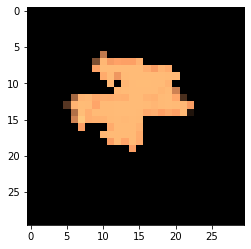

In [46]:
im = sim.get_biomass_image('toy', 1500)
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))
plt.imshow(im, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)


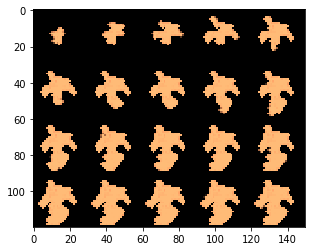

In [47]:
big_image = np.zeros((grid_size * 4, grid_size * 5))
im_cycles = np.arange(p.all_params["BiomassLogRate"], p.all_params["maxCycles"] + p.all_params["BiomassLogRate"],
                      p.all_params["BiomassLogRate"])
for i, cycle in enumerate(im_cycles):
    big_image[(grid_size * int(i / 5)):(grid_size + grid_size * int(i / 5)),(grid_size * (i % 5)):(grid_size + grid_size * (i % 5))] = sim.get_biomass_image("toy", cycle)
    plt.imshow(big_image, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)